In [1]:
%load_ext autoreload
%autoreload 2
import sys
import numpy as np
import pandas as pd
import scipy.sparse as sparse
from pathlib import Path
from glob import glob
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from typing import List, Dict, Any, Optional

## Data preprocessing
First, we have to preprocessing the data and convert them to numpy ndarray.

### Load data (Training Required)
Load data and apply normalization technique to each sentences.

In [2]:
from preprocess import preprocess_sentence

In [3]:
# load normal covid19 datasets
p_sent_list: List[str] = list()
for filepath in glob("covid19-tweets-clean/*.txt"):
    with open(filepath, "r", encoding="utf8") as fp:
        p_sent_list.extend(fp.readlines())
p_sent_list = list(map(lambda x: x.strip(), p_sent_list))
p_list: List[List[str]] = list()
for sent in tqdm(p_sent_list):
    p_list.append(preprocess_sentence(sent))

100%|██████████| 8239/8239 [00:13<00:00, 601.28it/s]


In [4]:
# load anti-vac datasets
n_sent_list: List[str] = list()
for filepath in glob("avax-tweets-clean/*.txt"):
    with open(filepath, "r", encoding="utf8") as fp:
        n_sent_list.extend(fp.readlines())
n_list: List[List[str]] = list()
for sent in tqdm(n_sent_list):
    n_list.append(preprocess_sentence(sent))

100%|██████████| 6266/6266 [00:09<00:00, 661.49it/s]


### Word embedding Train (First time training required)
TF-IDF

In [5]:
from gensim.models.tfidfmodel import TfidfModel
from gensim.corpora import Dictionary

all_list = p_list + n_list
dct = Dictionary(all_list)
dct.filter_extremes(no_below=5, no_above=0.3)
corpus = [dct.doc2bow(words) for words in all_list]

tfidf_emb_model = TfidfModel(corpus)
model_dir = Path("models/")
model_dir.mkdir(exist_ok=True)
tfidf_emb_model.save(str(model_dir.joinpath(f"tfidf_emb.pkl")))
dct.save(str(model_dir.joinpath("dictionary.pkl")))

### Word embedding model load (Always Required)
Load the existing tfidf embedding model.

In [6]:
from gensim.models.tfidfmodel import TfidfModel
from gensim.corpora import Dictionary

tfidf_emb_model_path = Path("models/tfidf_emb.pkl")
dictionary_path = Path("models/dictionary.pkl")
if tfidf_emb_model_path.exists():
    tfidf_emb_model: TfidfModel = TfidfModel.load(str(tfidf_emb_model_path))
    dct: Dictionary = Dictionary.load(str(dictionary_path))
else:
    sys.stderr.write("TfIdf embedding model or dictionary not found.\n")
    sys.exit(-1)

### Transforming docs to vectors (Training Required)
It's time to transform these documents into `scipy.sparse.csr_matrix`.


In [7]:
indices_ptr = list()
indices_ptr.append(0)
col_indices = list()
csr_data = list()
for i, words in enumerate(p_list):
    tfidf_result = tfidf_emb_model[dct.doc2bow(words)]
    indices_ptr.append(indices_ptr[-1] + len(tfidf_result))
    col_indices.extend([r[0] for r in tfidf_result])
    csr_data.extend([r[1] for r in tfidf_result])
for i, words in enumerate(n_list):
    tfidf_result = tfidf_emb_model[dct.doc2bow(words)]
    indices_ptr.append(indices_ptr[-1] + len(tfidf_result))
    col_indices.extend([r[0] for r in tfidf_result])
    csr_data.extend([r[1] for r in tfidf_result])
# construct the csr matrix and gold labels
X: sparse.csr_matrix = sparse.csr_matrix((csr_data, col_indices, indices_ptr))
y = np.zeros(len(p_list) + len(n_list), dtype=int)
y[:len(p_list)] = 1

### Split training and testing sets (Training Required)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=True)

## Training
In this section, we shall train some models to fit the ground-truth classifier.

### XGBoost
In this section, we choose `XGBoost` as the classifier.

In [9]:
import xgboost as xgb

weights_train = np.zeros(X_train.shape[0])
weights_train[y_train == 0] = np.sum(y_train == 1) / X_train.shape[0]
weights_train[y_train == 1] = np.sum(y_train == 0) / X_train.shape[0]
data_train = xgb.DMatrix(X_train, label=y_train, weight=weights_train)
data_test = xgb.DMatrix(X_test, label=y_test)
xgb_params = {
    "learning_rate": 0.2,
    "booster": "dart",
    "objective": "binary:logistic",
    "max_depth": 50,
    "lambda": 10., # L2 regularization
    "eval_metric": ["logloss", "error"],
    "rate_drop": 0.1,
    "skip_drop": 0.5,
}
eval_list = [(data_train, "train"), (data_test, "eval")]

In [10]:
# If u want to train, set `XGB_TRAIN` to `True`
XGB_TRAIN = True
XGB_MODEL_FILEPATH = "models/xgb.model"
if XGB_TRAIN:
    num_rounds = 50
    bst: xgb.Booster = xgb.train(xgb_params, data_train, num_rounds, eval_list)
    bst.save_model(XGB_MODEL_FILEPATH)
else:
    bst = xgb.Booster(xgb_params)
    bst.load_model(XGB_MODEL_FILEPATH)

[0]	train-logloss:0.57734	train-error:0.10091	eval-logloss:0.58051	eval-error:0.12681
[1]	train-logloss:0.49638	train-error:0.09389	eval-logloss:0.50239	eval-error:0.11716
[2]	train-logloss:0.43708	train-error:0.09421	eval-logloss:0.44611	eval-error:0.11716
[3]	train-logloss:0.39187	train-error:0.09080	eval-logloss:0.40465	eval-error:0.11647
[4]	train-logloss:0.35555	train-error:0.08401	eval-logloss:0.37320	eval-error:0.11234
[5]	train-logloss:0.32694	train-error:0.08162	eval-logloss:0.34854	eval-error:0.11027
[6]	train-logloss:0.30371	train-error:0.08244	eval-logloss:0.32805	eval-error:0.10820
[7]	train-logloss:0.28452	train-error:0.07963	eval-logloss:0.31286	eval-error:0.10889
[8]	train-logloss:0.26842	train-error:0.07686	eval-logloss:0.30116	eval-error:0.10820
[9]	train-logloss:0.25533	train-error:0.07533	eval-logloss:0.29154	eval-error:0.10407
[10]	train-logloss:0.24417	train-error:0.07322	eval-logloss:0.28384	eval-error:0.10751
[11]	train-logloss:0.23466	train-error:0.07309	eval-l

## Evaluation
In this section, we apply some methods of evaluating to prove that this experiment is done successfully.

In [11]:
# construct y_pred
y_pred = bst.predict(data_test)
y_pred[y_pred >= 0.5] = 1
y_pred[y_pred < 0.5] = 0
y_pred = y_pred.astype(int)

### LogLoss & Error rate

In [12]:
print(bst.eval(data_test))

[0]	eval-logloss:0.242798	eval-error:0.101999


### Confusion matrix
In the confusion matrix, **0** represent the sentiment prone to anti-vaccination, and **1** vice versa.

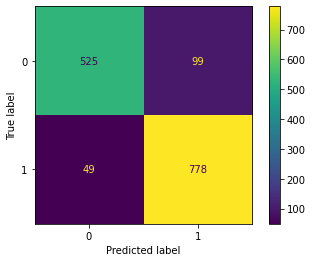

In [25]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y_test, y_pred).figure_.savefig("confusion.png", dpi=200)

### F1 score

In [28]:
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score
print(f"F1 Score: {f1_score(y_test, y_pred)}")
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Precision: {precision_score(y_test, y_pred)}")
print(f"Recall: {recall_score(y_test, y_pred)}")

F1 Score: 0.9131455399061034
Accuracy: 0.8980013783597519
Precision: 0.887115165336374
Recall: 0.9407496977025392


## Test by yourself
Now, you can test whether a sentence is has an anti-vaccination sentiment.
Try it yourself :)

In [15]:
import xgboost as xgb
from preprocess import preprocess_sentence
from typing import Tuple
def predict_sentence(sentence: str) -> Tuple[str, float]:
    words: List[str] = preprocess_sentence(sentence)
    tfidf_result = tfidf_emb_model[dct.doc2bow(words)]
    if len(tfidf_result) == 0:
        return "Unknown", -1.
    indptr = [0, len(tfidf_result)]
    indices = [r[0] for r in tfidf_result]
    data = [r[1] for r in tfidf_result]
    mat = sparse.csr_matrix((data, indices, indptr))
    dmat = xgb.DMatrix(mat)
    predict_result = bst.predict(dmat)
    if predict_result[0] >= 0.5:
        return "others", predict_result[0]
    else:
        return "anti-vaccination like", predict_result[0]

In [16]:
predict_sentence("Vaccines gonna kill us all. The government is lying! HERE COMES THE DEPOPULATION!")

('anti-vaccination like', 0.012458286)